# Lista de Exercícios \#6
## Breno Vieira Arosa

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams.update({'font.size': 14})

## Questão 1
### Describe the main components necessary to add to a "standard" EA in order to tackle a multiobjective problem.

Para atingir bons resultados em problemas multi-objetivos é necessário obter soluções pertencentes ao ótimo de Pareto.
O conjunto de ótimos de Pareto é definido pelo conjunto de soluções que não são dominadas por outras soluções, isto é, não possuem nenhuma solução na qual o valor de fitness de todos os objetivos são igual ou melhores que a própria.

O primeiro, e mais simples, algoritmo evolucionário multi-objetivo é o VEGA.
O VEGA consiste em separar a população em subpopulações e atribuir um objetivo a cada uma delas, a partir desse ponto o algoritmo evolucionário seguirá seu processo de busca ao ótimo desse objetivo.

Porém, o VEGA é capaz de gerar soluções do conjunto de Pareto apenas por poucas gerações.
Outras abordagens evolucionárias se voltaram ao problema multi-objetivo, separando-as em duas abordagens: elitistas e não-elitistas.

Abordagens Não-Elitistas:
- MOGA: Utiliza como fitness o número de indivíduos da população que um determinado indivíduo domina. "Fitness sharing" é utilizado para garantir a variedade de soluções.
- NSGA: Utiliza o mesmo conceito que a MOGA porém divide a população em subpopulações baseadas em seu ranking. O fitness de cada subpopulação será determinado pelo número de índividuos em supopulações piores. Fitness sharing também é utilizado para garantir a variedade das soluções.
- NPGA: Neste caso, se modifica o algoritmo de maneira que a seleção de pais é feita a partir de um torneio modificado para multi-objetivo. O torneio compara dois indivíduos considerando primeiro se um domina o outro e posteriormente o número de soluções parecidas na população.

Abordagens Elitistas:  
Podem ser obtidas a partir de algoritmos como o NSGA-II, SPEA-II e PAES.
O algoritmo NSGA-II utiliza uma métrica de distância entre indivíduos.
A seleção de sobreviventes a partir da soma das populações de pais e de filhos e a seleção é feita considerando a distância entre indivíduos.
A seleção de pais, de forma semelhante, também leva em consideração a métrica de distância.

## Questão 2

In [3]:
def onemax(populacao):
    return populacao.sum(axis=1)

In [4]:
class MemeticSGA(object):
    
    def __init__(self, binary_size, population_size,
                 fitness_func, mutation_rate):
        self.binary_size = binary_size
        self.population_size = population_size
        self.fitness_func = fitness_func
        self.mutation_rate = mutation_rate
        
        self.population = self.init_population()
    
    
    def repr_str2matrix(self, population):
        """
        Represent population as a 2D matrix.
        """
        arr = np.zeros((len(population), self.binary_size)).astype("uint8")
        for i, x in enumerate(sga.population):
            arr[i, :] = np.array(list(x)).astype("uint8")
        return arr
    
    
    def repr_matrix2str(self, population):
        """
        Represent population as a vector of binary strings.
        """
        population = population.astype(int)
        matrix2str = lambda x: "".join(map(str, x))
        return np.apply_along_axis(matrix2str, axis=1, arr=population)
    
    
    def init_population(self):
        """
        Initialize binary vectors.
        """
        x0 = np.random.randint(low=0, high=2,
                               size=(self.population_size, self.binary_size),
                               dtype="uint8")
        return x0
    
    
    def evaluate(self, population):
        return self.fitness_func(population)
    
    
    def mutate(self, rate):
        """
        Bitwise Mutation.
        
        Mutate bits with given rate.
        """
        population = self.population.copy().astype(bool)
        mutation_rand = np.random.uniform(size=(self.population_size, self.binary_size))
        
        # invert bit if random sample < mutation rate
        population[mutation_rand < rate] = ~population[mutation_rand < rate]
        return population.astype("uint8")
    
    
    def recombine(self, parents):
        """
        One-Point Crossover.
        
        The formation of pairs are randomized.
        100% children are formed from recombination (crossover rate = 1).
        The point of crossover is randomized for each pair.
        Two children are created per pair of parents.
        """
        
        # shuffle parents before form pairs
        parents = parents.copy()
        np.random.shuffle(parents)
        
        # form pairs of parents
        parents = parents.reshape(-1, 2, self.binary_size)
                
        # defines the multiplier pattern to match crossover
        cross_multiplier = np.ones((parents.shape[0], 2, self.binary_size), dtype="uint8")
        for i in range(parents.shape[0]):
            # defines the point of crossover
            # there is no crossover if point equals 0 or (binary_size-1)
            cross_idx = np.random.randint(low=1, high=(self.binary_size - 2))
            cross_multiplier[i, 0, cross_idx:self.binary_size] = 0
            cross_multiplier[i, 1, 0:cross_idx] = 0
        
        # multipliers parent pairs by crossover pattern and anti-pattern
        # developing the same number of children as parents
        children_top = (parents * cross_multiplier).sum(axis=1)
        children_bot = (parents * (~cross_multiplier.astype(bool)).astype("uint8")).sum(axis=1)
        children = np.vstack((children_top, children_bot))
        
        return children

                             
    def parent_selection(self, s=1.5):
        """
        Generational model.
        Linear Ranking Selection with Roullete Wheel probabilities.
        """
        
        fitness = self.evaluate(self.population)
        rank = stats.rankdata(fitness, "ordinal")
        u = self.population_size     
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)

        return self.population[select_idx, :]

    
    def natural_selection(self, parents, children, s=1.5):
        """
        Fitness-Based Replacement.
        Linear Ranking Selection with Roullete Wheel probabilities
        """
        population = np.concatenate((parents, children))
        
        fitness = self.evaluate(population)
        rank = stats.rankdata(fitness, "ordinal")
        u = len(population)   
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)
        
        return population[select_idx, :]

    
    def local_seach(self, population, neigh_n=10):
        """
        Bit-Flipping Local Search.
        """
        
        for i in range(self.population_size):
            # create a neighborhood with copies of original individual
            neighborhood = population[i, :].reshape(1, -1).repeat((neigh_n+1), axis=0)
            # select bit positions to flip
            bit_positions = np.random.choice(self.binary_size, size=(neigh_n), replace=False)
            
            # bit flipping
            neighborhood[np.arange(1, neigh_n+1), bit_positions] += 1
            neighborhood = neighborhood % 2
            
            # changes original individual by it best neighbor
            fitness = self.evaluate(neighborhood)
            population[i, :] = neighborhood[fitness.argmax(), :].copy()
            
        return population

    
    def evolve(self):
        parents = self.parent_selection(s=1.5)
        offspring = self.recombine(parents)
        offspring = self.mutate(self.mutation_rate)
        offspring = self.local_seach(offspring)
        self.population = self.natural_selection(parents, offspring, s=1.5)
        return

In [5]:
sga = MemeticSGA(binary_size=25, population_size=100,
                 fitness_func=onemax, mutation_rate=1/25)

In [6]:
N = 100

history = np.zeros((N, sga.population_size, sga.binary_size))
for i in range(N):
    history[i, :, :] = sga.population.copy()
    sga.evolve()

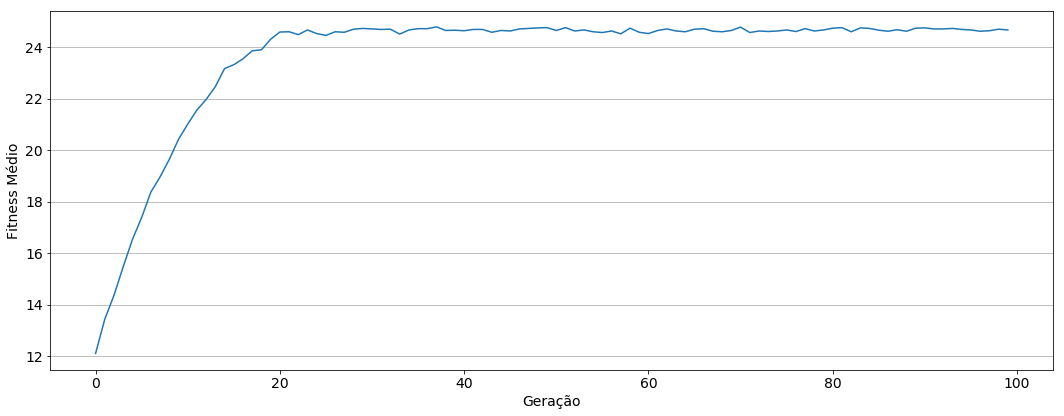

In [7]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = sga.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()